In [2]:
# General Imports
import numpy as np
import csv
from datetime import datetime as time
import os

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
# TeX Label Config
import matplotlib as mpl
mpl.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': 'cmr10',
    'mathtext.fontset': 'cm',
    'font.family': 'STIXGeneral',
    'font.size': 12,
    'axes.unicode_minus': True,
    'figure.autolayout': True,
    'legend.fontsize': 'large'
    })

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.model_selection import train_test_split

# tqdm for progress bar
from tqdm import trange, tqdm

# ipython config
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
n_states = 1000
X = np.array([np.random.uniform(low=-1, high=1, size=3) for _ in range(n_states)])
y = X.copy()

X_train, X_left, y_train, y_left = train_test_split(
    X, y, test_size=0.3, random_state=42)

X_valid, X_treasure, y_valid, y_treasure = train_test_split(
    X_left, y_left, test_size=0.4, random_state=42)

X.shape
y.shape
X_train.shape[0]
X_valid.shape[0]
X_treasure.shape[0]

(1000, 3)

(1000, 3)

700

180

120

In [4]:
sum((X - y) > 1e-10)

array([0, 0, 0])

X and y are identical

In [5]:
class CustomDataset(Dataset):

  def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

  def __len__(self):
        return self.X.shape[0]

  def __getitem__(self, index):
        # Select sample
        X = self.X[index]

        # Load data and get label
        x = self.X[index]
        y = self.Y[index]

        return x, y

In [6]:
tomography_train_dataset = CustomDataset(X_train, y_train)
tomography_valid_dataset = CustomDataset(X_valid, y_valid)
tomography_treasure_dataset = CustomDataset(X_treasure, y_treasure)

In [7]:
# Define the batch sizes
BATCH_SIZE = 32

# Create data loaders from the datasets for the current task
# Shuffle not necessary as samples are generated at random
# Setting drop_last=True does not consider the last batch in which there are less than BATCH_SIZE examples
tomography_train_dataloader = DataLoader(tomography_train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
tomography_vaild_dataloader = DataLoader(tomography_valid_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

Feed Forward Neural Network

In [8]:
class FeedForwardNet(nn.Module):

  def __init__(self):
    super().__init__()

    self.layers = nn.Sequential(
    nn.Linear(3, 16),
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,3),
    )

  def forward(self, x):
    return self.layers(x)

In [9]:
# Function for training the network
def train(net, n_epochs, train_dataloader, optimizer, criterion):
    net.train()
    
    losses = np.array([])

    for epoch in trange(n_epochs):

        for batch_idx, samples in enumerate(train_dataloader):
            data, target = samples[0].to(device), samples[1].to(device)
            # Optimize parameters
            net.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            losses = np.append(losses, loss.clone().detach().cpu().numpy())

    return losses

In [14]:
# Check if the GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Create the network on the CPU/GPU
net = FeedForwardNet().to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

losses = train(net, 400, tomography_train_dataloader, optimizer, criterion)

cpu


100%|██████████| 400/400 [00:02<00:00, 143.69it/s]


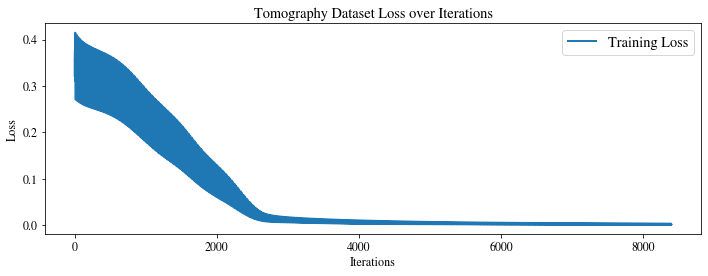

In [15]:
a=plt.figure(figsize=(10,4))
a=plt.plot(losses, lw=2, label='Training Loss')
a=plt.xlabel('Iterations')
a=plt.ylabel('Loss')
a=plt.legend()
a=plt.title('Tomography Dataset Loss over Iterations')

# Inference

In [282]:
rho_orig = random_mixed_bloch()
measurement = torch.Tensor(perform_measurements(bloch2mat(rho_orig), data_obs))
rho_pred = net.forward(measurement.to(device)).detach().cpu().numpy()

rho_orig
rho_pred

array([-0.06072047,  0.01387239, -0.0044459 ])

array([-0.00817471, -0.00525232, -0.00833925], dtype=float32)

In [262]:
rho_orig = np.real(bloch2mat(random_mixed_bloch()))
measurement = torch.Tensor(perform_measurements(rho_orig, data_obs))
rho_pred = net.forward(measurement.to(device)).detach().cpu().numpy()

print(rho_orig.reshape(4))
print(rho_pred.reshape(4))
fig, axs = plt.subplots(1,2, figsize=(10,4))
a=axs[0].imshow(rho_orig, vmin=0, vmax=1)
a=axs[0].set_title('$\\rho$ original')
a=axs[1].set_title('$\\rho$ prediction')
a=axs[1].imshow(rho_pred, vmin=0, vmax=1)
a=fig.colorbar(a)

[ 0.88771397 -0.2667599  -0.2667599   0.11228603]


ValueError: cannot reshape array of size 3 into shape (4,)

Lernt nur den Durchschnitt!

Verbesserungsansätze: 
- netzwerk vergrößern
  - nichts gebracht
- andere loss function mit mehr gewicht für outliers
  - bereits MSE verwendet, was mehr weight auf outliers gibt as MAE=L1, konvergiert bei 0.02 training loss
  - MAE bringt nichts, resultiert in 0.7 training loss
- berücksichtigen, dass information auf offdiagonaler redundant ist
  - siehe neues notebook error von bloch vektoren

Briegel fragen was genau es bringt im AE nicht über die dichtematrix zu gehen sondern direkt auf kompakteste repräsentation zu lernen.

In [ ]:
x, y = np.random.rand(2, 100) * 4
x
y

array([2.96389626, 1.73596508, 1.16719767, 1.11422471, 2.79862357,
       2.35721398, 3.93870914, 1.08933727, 3.87450093, 2.80199897,
       3.45478582, 3.46806942, 2.05828875, 1.17761769, 3.63073728,
       2.28366101, 2.51618012, 3.69455026, 0.78492579, 3.73850266,
       3.32340991, 1.68444666, 3.32616995, 1.69974554, 0.87992278,
       3.93054026, 1.52805315, 2.95671699, 0.42796306, 0.78407417,
       2.90195964, 3.0944868 , 1.70316047, 1.52801833, 0.89463666,
       2.32060716, 2.75311762, 2.79046422, 0.25092932, 3.01100054,
       0.11780293, 3.05798942, 2.90091635, 1.48425788, 2.59827939,
       0.57603278, 1.8565093 , 2.22856851, 2.30753899, 0.83030343,
       0.00450815, 3.00708237, 3.93136616, 1.06596202, 0.43366389,
       0.58625285, 2.73280636, 0.48712994, 2.05292224, 1.72184533,
       2.81807684, 2.82042757, 3.4829603 , 1.13573099, 3.59716792,
       2.29971685, 0.16469145, 2.85345621, 3.88961335, 2.896654  ,
       3.62849564, 1.67901004, 3.41455596, 1.74269363, 3.79929

array([0.26867795, 0.30074934, 2.39611794, 1.1476739 , 1.22020531,
       1.55605514, 3.68419356, 1.65704712, 1.63337846, 1.3722961 ,
       3.56560137, 2.6224129 , 2.01070269, 2.80071181, 0.29997742,
       1.78940427, 3.51051516, 2.17709476, 3.41081933, 2.15520163,
       0.63391747, 2.36973307, 0.11544576, 1.49322091, 1.69989613,
       0.31237659, 2.14538843, 0.19008319, 0.52192266, 3.50600615,
       2.72260254, 0.98631097, 3.52336013, 2.94008889, 1.15216547,
       3.03416411, 3.92298049, 3.86697789, 2.33750238, 3.87374848,
       2.19543175, 1.92430195, 1.26644586, 0.70927637, 2.2154165 ,
       2.7049417 , 0.10715601, 3.84229066, 0.27570694, 1.28032469,
       3.78968639, 2.58013421, 0.3033705 , 1.10081229, 1.76426388,
       1.03640905, 2.05545748, 3.32411982, 1.27921449, 1.04648534,
       2.06128637, 1.2156759 , 0.6373917 , 3.1302815 , 1.93064114,
       2.88144918, 3.78890452, 0.40856341, 1.6140164 , 1.67637081,
       1.54768078, 0.30113711, 1.83859163, 2.08235783, 1.17093